In [23]:
import os
import json
from pathlib import Path
from datetime import timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from influx_io import get_client, INFLUX_BUCKET, INFLUX_ORG

RANDOM_STATE = 42

OUT_DIR = Path("ml_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

assert abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) < 1e-9


In [2]:
#%pip install numpy pandas scikit-learn matplotlib pyarrow


In [25]:
# =========================================
# FIXED Influx loaders (no 'usid' in pivot rowKey)
# =========================================
import pandas as pd

def influx_query_df(flux: str) -> pd.DataFrame:
    with get_client() as client:
        q = client.query_api()
        tables = q.query(flux, org=INFLUX_ORG)

    rows = []
    for table in tables:
        for record in table.records:
            rows.append(dict(record.values))

    return pd.DataFrame(rows) if rows else pd.DataFrame()


def load_orf_articles(lookback: str = "180d") -> pd.DataFrame:
    # pivot on _time only, then keep usid/category (tags) that come along
    flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{lookback})
  |> filter(fn: (r) => r._measurement == "orf_article")
  |> filter(fn: (r) => r._field == "title" or r._field == "link")
  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
'''
    df = influx_query_df(flux)
    if df.empty:
        return df

    # Keep only what we need (if present)
    want = [c for c in ["_time", "usid", "category", "title", "link"] if c in df.columns]
    df = df[want].copy()

    # Clean types
    df = df.rename(columns={"_time": "article_time"})
    df["article_time"] = pd.to_datetime(df["article_time"], utc=True, errors="coerce")

    if "usid" in df.columns:
        df["usid"] = df["usid"].astype(str)
    else:
        raise RuntimeError("Column 'usid' not returned by query. Check if tag name is really 'usid' in Influx.")

    if "category" in df.columns:
        df["category"] = df["category"].astype(str)
    else:
        df["category"] = "unknown"

    if "title" in df.columns:
        df["title"] = df["title"].astype(str)
    else:
        df["title"] = ""

    if "link" in df.columns:
        df["link"] = df["link"].astype(str)
    else:
        df["link"] = ""

    # Final cleanup
    df = df.dropna(subset=["article_time", "usid"])
    df = df.sort_values("article_time").drop_duplicates(subset=["usid"], keep="last")
    return df


def load_reddit_posts(lookback: str = "180d") -> pd.DataFrame:
    flux = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{lookback})
  |> filter(fn: (r) => r._measurement == "reddit_post")
  |> filter(fn: (r) => r._field == "reddit_id" or r._field == "checked_word_count" or r._field == "group_matches_in_window" or r._field == "title" or r._field == "permalink" or r._field == "url")
  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
'''
    df = influx_query_df(flux)
    if df.empty:
        return df

    want = [c for c in ["_time", "usid", "source", "reddit_id", "checked_word_count", "group_matches_in_window", "title", "permalink", "url"] if c in df.columns]
    df = df[want].copy()

    df = df.rename(columns={"_time": "saved_at"})
    df["saved_at"] = pd.to_datetime(df["saved_at"], utc=True, errors="coerce")

    if "usid" not in df.columns:
        raise RuntimeError("Column 'usid' not returned by query. Check tag name in Influx.")

    df["usid"] = df["usid"].astype(str)
    df["source"] = df["source"].astype(str) if "source" in df.columns else ""

    # numeric fields
    for col in ["checked_word_count", "group_matches_in_window"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
        else:
            df[col] = 0

    df["reddit_id"] = df["reddit_id"].astype(str) if "reddit_id" in df.columns else ""

    df = df.dropna(subset=["saved_at", "usid"])
    df = df[df["reddit_id"].astype(str).str.len() > 0]  # keep valid ids
    return df


In [26]:
# =========================================
# LOAD DATA (this is the missing step)
# =========================================
df_articles = load_orf_articles("365d")
df_reddit   = load_reddit_posts("365d")

print("df_articles:", df_articles.shape)
print("df_reddit:", df_reddit.shape)



df_articles: (16, 5)
df_reddit: (1452, 9)


In [12]:
print("df_articles exists:", "df_articles" in globals())
print("df_reddit exists:", "df_reddit" in globals())


df_articles exists: True
df_reddit exists: True


In [27]:
# Build ONE-ROW-PER-ARTICLE dataset (features + targets)
# Aggregate reddit per article usid
if df_reddit.empty:
    agg = pd.DataFrame(columns=["usid","reddit_match_count","avg_group_matches","avg_checked_word_count","unique_sources"])
else:
    agg = (
        df_reddit.groupby("usid", as_index=False)
        .agg(
            reddit_match_count=("reddit_id", "nunique"),
            avg_group_matches=("group_matches_in_window", "mean"),
            avg_checked_word_count=("checked_word_count", "mean"),
            unique_sources=("source", "nunique"),
        )
    )

# merge
df = df_articles.merge(agg, on="usid", how="left")

# bill missing reddit signals with 0
for col in ["reddit_match_count","avg_group_matches","avg_checked_word_count","unique_sources"]:
    df[col] = df[col].fillna(0)

# basic time + title features
df["hour_of_day"] = df["article_time"].dt.hour
df["day_of_week"] = df["article_time"].dt.dayofweek

df["title_len"] = df["title"].astype(str).str.len()
df["title_word_count"] = df["title"].astype(str).str.split().str.len()

# reaction score as before
df["reaction_score"] = df["reddit_match_count"] + 0.5 * df["avg_group_matches"]

# drop articles with no reddit reaction (optional, but helps a lot)
df = df[df["reaction_score"] > 0].copy()

# create a "high reaction" label using top 25% instead of median
q75 = float(df["reaction_score"].quantile(0.75))
df["reaction_high"] = (df["reaction_score"] >= q75).astype(int)

print("Rows after filter:", len(df))
print("Reaction_high balance:\n", df["reaction_high"].value_counts())
print("q75 threshold:", q75)



Rows after filter: 3
Reaction_high balance:
 reaction_high
0    2
1    1
Name: count, dtype: int64
q75 threshold: 692.045989043856


In [28]:
# time-aware split (train/val/test by date)
df = df.sort_values("article_time").reset_index(drop=True)

n = len(df)
n_train = int(n * TRAIN_RATIO)
n_val = int(n * VAL_RATIO)

df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train + n_val].copy()
df_test  = df.iloc[n_train + n_val:].copy()

print("Train/Val/Test:", len(df_train), len(df_val), len(df_test))

# Persist splits
df_train.to_parquet(OUT_DIR / "split_train.parquet", index=False)
df_val.to_parquet(OUT_DIR / "split_val.parquet", index=False)
df_test.to_parquet(OUT_DIR / "split_test.parquet", index=False)


Train/Val/Test: 2 0 1


In [29]:
print("Total rows:", len(df))
print("Train/Val/Test sizes:", len(df_train), len(df_val), len(df_test))
print("Class balance train:\n", df_train["reaction_high"].value_counts())
print("Class balance test:\n", df_test["reaction_high"].value_counts())


Total rows: 3
Train/Val/Test sizes: 2 0 1
Class balance train:
 reaction_high
1    1
0    1
Name: count, dtype: int64
Class balance test:
 reaction_high
0    1
Name: count, dtype: int64


In [30]:
# common feature pipeline (TF-IDF title + OneHot category + numeric)
TEXT_COL = "title"
CAT_COL = "category"
NUM_COLS = ["hour_of_day", "day_of_week", "title_len", "title_word_count"]


preprocess = ColumnTransformer(
    transformers=[
        ("title_tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=5000), TEXT_COL),
        ("cat_ohe", OneHotEncoder(handle_unknown="ignore"), [CAT_COL]),
        ("num", "passthrough", NUM_COLS),
    ],
    remainder="drop",
)

X_train = df_train[[TEXT_COL, CAT_COL] + NUM_COLS]
X_val   = df_val[[TEXT_COL, CAT_COL] + NUM_COLS]
X_test  = df_test[[TEXT_COL, CAT_COL] + NUM_COLS]

y_train_clf = df_train["reaction_high"]
y_val_clf   = df_val["reaction_high"]
y_test_clf  = df_test["reaction_high"]

y_train_reg = df_train["reaction_score"]
y_val_reg   = df_val["reaction_score"]
y_test_reg  = df_test["reaction_score"]


In [31]:
# RandomForest CLASSIFICATION (reaction_high)
clf = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=400,
            random_state=RANDOM_STATE,
            class_weight="balanced",
            n_jobs=-1
        )),
    ]
)

clf.fit(X_train, y_train_clf)

val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)

print("VAL report:\n", classification_report(y_val_clf, val_pred, digits=3))
print("TEST report:\n", classification_report(y_test_clf, test_pred, digits=3))

# Confusion matrix plot (test)
cm = confusion_matrix(y_test_clf, test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title("Confusion Matrix (Test) — reaction_high")
plt.show()

# Save metrics + predictions
clf_metrics = {
    "median_score_threshold": median_score,
    "val_report": classification_report(y_val_clf, val_pred, digits=3, output_dict=True),
    "test_report": classification_report(y_test_clf, test_pred, digits=3, output_dict=True),
    "test_confusion_matrix": cm.tolist(),
}

with open(OUT_DIR / "rf_classifier_metrics.json", "w", encoding="utf-8") as f:
    json.dump(clf_metrics, f, indent=2)

preds_clf = df_test[["usid","article_time","title","category","reaction_score","reaction_high"]].copy()
preds_clf["pred_reaction_high"] = test_pred.astype(int)
preds_clf.to_csv(OUT_DIR / "rf_classifier_predictions_test.csv", index=False, encoding="utf-8")
preds_clf.to_parquet(OUT_DIR / "rf_classifier_predictions_test.parquet", index=False)

print("Saved classifier outputs to:", OUT_DIR)


ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [18]:
# RandomForest REGRESSION (reaction_score)
reg = Pipeline(
    steps=[
        ("prep", preprocess),
        ("model", RandomForestRegressor(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )),
    ]
)

reg.fit(X_train, y_train_reg)

val_pred_r = reg.predict(X_val)
test_pred_r = reg.predict(X_test)

rmse_val = float(np.sqrt(mean_squared_error(y_val_reg, val_pred_r)))
mae_val = float(mean_absolute_error(y_val_reg, val_pred_r))
r2_val = float(r2_score(y_val_reg, val_pred_r))

rmse_test = float(np.sqrt(mean_squared_error(y_test_reg, test_pred_r)))
mae_test = float(mean_absolute_error(y_test_reg, test_pred_r))
r2_test = float(r2_score(y_test_reg, test_pred_r))

print("VAL  RMSE/MAE/R2:", rmse_val, mae_val, r2_val)
print("TEST RMSE/MAE/R2:", rmse_test, mae_test, r2_test)

reg_metrics = {
    "median_score_threshold": median_score,
    "val": {"rmse": rmse_val, "mae": mae_val, "r2": r2_val},
    "test": {"rmse": rmse_test, "mae": mae_test, "r2": r2_test},
}

with open(OUT_DIR / "rf_regressor_metrics.json", "w", encoding="utf-8") as f:
    json.dump(reg_metrics, f, indent=2)

preds_reg = df_test[["usid","article_time","title","category","reaction_score","reaction_high"]].copy()
preds_reg["pred_reaction_score"] = test_pred_r
preds_reg.to_csv(OUT_DIR / "rf_regressor_predictions_test.csv", index=False, encoding="utf-8")
preds_reg.to_parquet(OUT_DIR / "rf_regressor_predictions_test.parquet", index=False)

print("Saved regressor outputs to:", OUT_DIR)


VAL  RMSE/MAE/R2: 0.0 0.0 1.0
TEST RMSE/MAE/R2: 343.65153353405105 280.50295818509994 -311.3600841186991
Saved regressor outputs to: ml_outputs


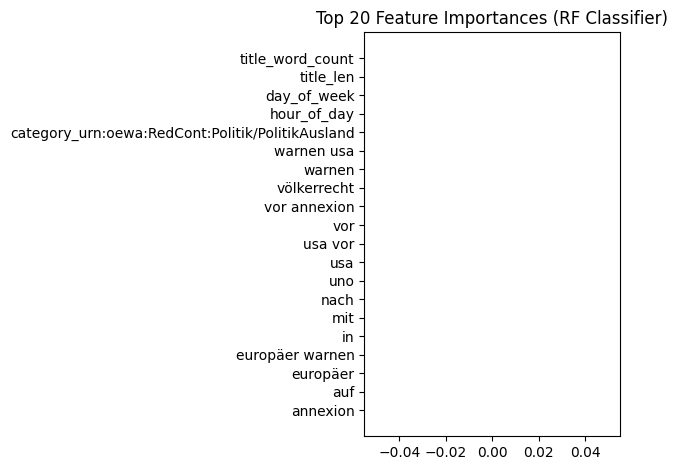

In [19]:
# feature importance (simple, readable)
# To get feature names out of the pipeline:
prep_fitted = clf.named_steps["prep"]
rf_model = clf.named_steps["model"]

tfidf = prep_fitted.named_transformers_["title_tfidf"]
ohe = prep_fitted.named_transformers_["cat_ohe"]

tfidf_names = tfidf.get_feature_names_out()
ohe_names = ohe.get_feature_names_out([CAT_COL])

feature_names = np.concatenate([tfidf_names, ohe_names, np.array(NUM_COLS, dtype=object)])
importances = rf_model.feature_importances_

imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False)

# Save importance
imp_df.to_csv(OUT_DIR / "rf_classifier_feature_importance.csv", index=False, encoding="utf-8")

# Plot top 20
topn = imp_df.head(20).sort_values("importance")
plt.figure()
plt.barh(topn["feature"], topn["importance"])
plt.title("Top 20 Feature Importances (RF Classifier)")
plt.tight_layout()
plt.show()


In [20]:
# one combined results file
# Merge classifier + regressor predictions for the test set into ONE table
combined = df_test[["usid","article_time","title","category","reaction_score","reaction_high"]].copy()

# Load from saved files (so analysis is decoupled from training)
pred_clf = pd.read_parquet(OUT_DIR / "rf_classifier_predictions_test.parquet")[["usid","pred_reaction_high"]]
pred_reg = pd.read_parquet(OUT_DIR / "rf_regressor_predictions_test.parquet")[["usid","pred_reaction_score"]]

combined = combined.merge(pred_clf, on="usid", how="left").merge(pred_reg, on="usid", how="left")

combined.to_csv(OUT_DIR / "ml_test_predictions_combined.csv", index=False, encoding="utf-8")
combined.to_parquet(OUT_DIR / "ml_test_predictions_combined.parquet", index=False)

print("Wrote combined file:", OUT_DIR / "ml_test_predictions_combined.csv")
combined.head(5)


Wrote combined file: ml_outputs\ml_test_predictions_combined.csv


,usid,article_time,title,category,reaction_score,reaction_high,pred_reaction_high,pred_reaction_score
0,news:3416363,2026-01-06 15:39:03+00:00,Kolumbien: Militär muss sich US-Invasion entge...,urn:oewa:RedCont:Politik/PolitikAusland,0.000000,1,1,0.000000
1,news:3416368,2026-01-06 16:56:31+00:00,Terrorermittlungen nach Angriff auf Berliner S...,urn:oewa:RedCont:Politik/PolitikAusland,47.521739,1,1,457.775307
2,news:3416373,2026-01-06 18:21:58+00:00,Insider: Italien wird für Mercosur-Abkommen st...,urn:oewa:RedCont:Politik/PolitikAusland,26.520000,1,1,457.775307
